In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models

import pandas as pd
import numpy as np
from PIL import Image
from pathlib import Path
import math
import matplotlib.pyplot as plt
import joblib
from sklearn.preprocessing import MinMaxScaler
from tqdm.auto import tqdm

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
!unzip /content/drive/MyDrive/nutrition5k-main/preprocess/data.zip -d /content/drive/MyDrive/nutrition5k-main/preprocess/data

Archive:  /content/drive/MyDrive/nutrition5k-main/preprocess/data.zip


In [ ]:
!cp -r /content/drive/MyDrive/nutrition5k-main/preprocess/data /content/data

^C


# 1. Data Loading and Scaling

In [3]:
# Load your dataframe (the same JSON file as before)
filepath = '/content/drive/MyDrive/Colab Notebooks/nutrition5k-main/preprocess/filtered_data.json'
df = pd.read_json(filepath, dtype={'total_mass': 'float64'})

In [4]:
df.head()

,id,total_calories,total_mass,total_fat,total_carb,total_protein,label,image_link,split
0,dish_1561662216,300.794281,193.0,12.387489,28.21829,18.63397,"[brown rice, pork, mixed greens]",./data/dish_1561662216/camera_A_frame_002.jpeg,test
1,dish_1561662216,300.794281,193.0,12.387489,28.21829,18.63397,"[brown rice, pork, mixed greens]",./data/dish_1561662216/camera_D_frame_002.jpeg,test
2,dish_1561662216,300.794281,193.0,12.387489,28.21829,18.63397,"[brown rice, pork, mixed greens]",./data/dish_1561662216/camera_C_frame_002.jpeg,test
3,dish_1561662216,300.794281,193.0,12.387489,28.21829,18.63397,"[brown rice, pork, mixed greens]",./data/dish_1561662216/camera_B_frame_002.jpeg,test
4,dish_1561662216,300.794281,193.0,12.387489,28.21829,18.63397,"[brown rice, pork, mixed greens]",./data/dish_1561662216/camera_B_frame_001.jpeg,test


In [6]:
# clean data

# Set the base directory where your image files are stored
base_dir = Path('/content/drive/MyDrive/Colab Notebooks/nutrition5k-main/preprocess')

# Function to check if a given image file exists
def image_exists(image_link):
    # Construct the full path to the image file
    img_path = base_dir / image_link
    # print(img_path)
    return img_path.exists()

In [7]:
# Apply the check to each row and store the result in a new column
df['exists'] = df['image_link'].apply(image_exists)

In [8]:
# Print summary of missing files
missing_count = (~df['exists']).sum()
print(f"Missing files: {missing_count} out of {len(df)}")

Missing files: 37288 out of 58296


In [9]:
# Remove rows where the image file is missing
df_cleaned = df[df['exists']].copy()
df_cleaned.drop(columns=['exists'], inplace=True)

In [2]:
# Optionally, save the cleaned DataFrame to a new JSON file
cleaned_path = '/content/drive/MyDrive/Colab Notebooks/nutrition5k-main/preprocess/filtered_data_cleaned.json'
df_cleaned.to_json(cleaned_path, orient='records')
print("Cleaned data saved to:", cleaned_path)

NameError: name 'df_cleaned' is not defined

In [5]:
# directly load cleaned df
df = pd.read_json('/content/drive/MyDrive/Colab Notebooks/nutrition5k-main/preprocess/filtered_data_cleaned.json', dtype={'total_mass': 'float64'})

In [9]:
print(len(df))

21008


In [11]:
df = df_cleaned.copy()

In [7]:
# Create a portion-independent version
df_portion_independent = df.copy()
df_portion_independent['protein_scaled'] = df_portion_independent['total_protein'] / df_portion_independent['total_mass']
df_portion_independent['fat_scaled'] = df_portion_independent['total_fat'] / df_portion_independent['total_mass']
df_portion_independent['carbs_scaled'] = df_portion_independent['total_carb'] / df_portion_independent['total_mass']

In [8]:
# Scaling function (same as before)
def scale(df, col):
    df = df.copy()
    scaler = MinMaxScaler()
    df[col] = scaler.fit_transform(df[col].to_numpy().reshape(-1, 1))
    return scaler, df

In [9]:
calorie_scaler, df = scale(df, 'total_calories')
mass_scaler, df = scale(df, 'total_mass')
fat_scaler, df = scale(df, 'total_fat')
carb_scaler, df = scale(df, 'total_carb')
protein_scaler, df = scale(df, 'total_protein')

In [ ]:
!mkdir /content/drive/MyDrive/nutrition5k-main/preprocess-new
!mkdir /content/drive/MyDrive/nutrition5k-main/preprocess-new/scalers

In [10]:
# Save scalers
joblib.dump(calorie_scaler, '/content/drive/MyDrive/Colab Notebooks/nutrition5k-main/preprocess-new/scalers/calorie_scaler.save')
joblib.dump(mass_scaler, '/content/drive/MyDrive/Colab Notebooks/nutrition5k-main/preprocess-new/scalers/mass_scaler.save')
joblib.dump(fat_scaler, '/content/drive/MyDrive/Colab Notebooks/nutrition5k-main/preprocess-new/scalers/fat_scaler.save')
joblib.dump(carb_scaler, '/content/drive/MyDrive/Colab Notebooks/nutrition5k-main/preprocess-new/scalers/carb_scaler.save')
joblib.dump(protein_scaler, '/content/drive/MyDrive/Colab Notebooks/nutrition5k-main/preprocess-new/scalers/protein_scaler.save')

['/content/drive/MyDrive/Colab Notebooks/nutrition5k-main/preprocess-new/scalers/protein_scaler.save']

In [10]:
def split_data(df):
    X_train = df[df['split'] == 'train']
    X_test = df[df['split'] == 'test']
    return X_train, X_test

In [11]:
X_train, X_test = split_data(df)
X_train_pi, X_test_pi = split_data(df_portion_independent)

In [12]:
print(len(X_train), len(X_test))
print(len(X_train_pi), len(X_test_pi))

17440 3568
17440 3568


# 2. Dataset and DataLoader

In [13]:
# Image and label column names / parameters
image_size = 320
batch_size = 32
directory = '/content/drive/MyDrive/Colab Notebooks/nutrition5k-main/preprocess'
x_col = 'image_link'
y_col = ['total_protein', 'total_fat', 'total_carb', 'total_mass']
y_col_pi = ['protein_scaled', 'fat_scaled', 'carbs_scaled']

In [14]:
class FoodDataset(Dataset):
    def __init__(self, df, y_cols, transform=None, base_dir=directory):
        self.df = df.reset_index(drop=True)
        self.y_cols = y_cols
        self.transform = transform
        self.base_dir = base_dir
        self.x_col = x_col

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = Path(self.base_dir) / row[self.x_col]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        # Get labels as numpy array (shape will be [4] for direct regression, [3] for portion independent)
        labels = row[self.y_cols].values.astype(np.float32)
        return image, labels

In [15]:
# Define transforms (data augmentation similar to ImageDataGenerator)
train_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(45),
    transforms.ColorJitter(brightness=(1, 1.5)),
    transforms.ToTensor(),
])
test_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
])

In [16]:
# Create datasets
train_dataset = FoodDataset(X_train, y_col, transform=train_transform)
test_dataset = FoodDataset(X_test, y_col, transform=test_transform)
train_dataset_pi = FoodDataset(X_train_pi, y_col_pi, transform=train_transform)
test_dataset_pi = FoodDataset(X_test_pi, y_col_pi, transform=test_transform)

In [17]:
# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
train_loader_pi = DataLoader(train_dataset_pi, batch_size=batch_size, shuffle=True)
test_loader_pi = DataLoader(test_dataset_pi, batch_size=batch_size, shuffle=False)

# 3. Model Definition

In [18]:
# For the base model, we use a pretrained ResNet18 and remove its final layer.
def get_base_model():
    base = models.resnet18(pretrained=True)
    modules = list(base.children())[:-1]  # remove the final fc layer
    base_model = nn.Sequential(*modules)
    # Freeze parameters
    for param in base_model.parameters():
        param.requires_grad = False
    return base_model

In [19]:
# model
base_model = get_base_model()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [20]:
# Define a branch similar to create_branch in your TF code.
class Branch(nn.Module):
    def __init__(self, in_features):
        super(Branch, self).__init__()
        self.fc1 = nn.Linear(in_features, 64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [21]:
# Multi-task model that attaches branches for each output.
class MultiTaskModel(nn.Module):
    def __init__(self, base_model, in_features, portion_independent=False):
        super(MultiTaskModel, self).__init__()
        self.base_model = base_model
        self.portion_independent = portion_independent
        self.protein_branch = Branch(in_features)
        self.fat_branch = Branch(in_features)
        self.carbs_branch = Branch(in_features)
        if not portion_independent:
            self.mass_branch = Branch(in_features)

    def forward(self, x):
        features = self.base_model(x)  # e.g., shape (batch, 512, 1, 1)
        features = features.view(features.size(0), -1)  # flatten to (batch, 512)
        protein = self.protein_branch(features)
        fat = self.fat_branch(features)
        carbs = self.carbs_branch(features)
        outputs = {'protein': protein, 'fat': fat, 'carbs': carbs}
        if not self.portion_independent:
            mass = self.mass_branch(features)
            outputs['mass'] = mass
        return outputs

In [22]:
# Instantiate models
in_features = 512  # for resnet18
direct_regression = MultiTaskModel(base_model, in_features, portion_independent=False).to(device)
portion_independent_model = MultiTaskModel(base_model, in_features, portion_independent=True).to(device)

# 4. Training Setup

In [23]:
# Set up optimizer and a learning rate scheduler similar to your callback.
learning_rate = 1e-4
optimizer_dr = optim.Adam(direct_regression.parameters(), lr=learning_rate)
optimizer_pi = optim.Adam(portion_independent_model.parameters(), lr=learning_rate)

In [24]:
def lr_lambda(epoch):
    if epoch < 4:
        return 1.0
    else:
        return math.exp(-0.1 * (epoch - 3))

In [25]:
scheduler_dr = LambdaLR(optimizer_dr, lr_lambda=lr_lambda)
scheduler_pi = LambdaLR(optimizer_pi, lr_lambda=lr_lambda)

In [26]:
# Training loop: calculates L1Loss for each branch and updates the model.
def train_model(model, optimizer, scheduler, train_loader, num_epochs, portion_independent=False):
    criterion = nn.L1Loss()
    history = {'loss': [], 'protein_loss': [], 'fat_loss': [], 'carbs_loss': []}
    if not portion_independent:
        history['mass_loss'] = []
    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_protein = 0.0
        running_fat = 0.0
        running_carbs = 0.0
        running_mass = 0.0

        # Use tqdm to show progress per epoch
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
        for images, labels in progress_bar:
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            optimizer.zero_grad()
            outputs = model(images)

            loss = 0.0
            protein_loss = criterion(outputs['protein'], labels[:, 0:1])
            fat_loss = criterion(outputs['fat'], labels[:, 1:2])
            carbs_loss = criterion(outputs['carbs'], labels[:, 2:3])
            loss += protein_loss + fat_loss + carbs_loss

            if not portion_independent:
                mass_loss = criterion(outputs['mass'], labels[:, 3:4])
                loss += mass_loss

            loss.backward()
            optimizer.step()

            batch_size = images.size(0)
            running_loss += loss.item() * batch_size
            running_protein += protein_loss.item() * batch_size
            running_fat += fat_loss.item() * batch_size
            running_carbs += carbs_loss.item() * batch_size
            if not portion_independent:
                running_mass += mass_loss.item() * batch_size

            progress_bar.set_postfix(loss=loss.item())

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_protein = running_protein / len(train_loader.dataset)
        epoch_fat = running_fat / len(train_loader.dataset)
        epoch_carbs = running_carbs / len(train_loader.dataset)

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")
        history['loss'].append(epoch_loss)
        history['protein_loss'].append(epoch_protein)
        history['fat_loss'].append(epoch_fat)
        history['carbs_loss'].append(epoch_carbs)
        if not portion_independent:
            epoch_mass = running_mass / len(train_loader.dataset)
            history['mass_loss'].append(epoch_mass)

        scheduler.step()

    return history

In [27]:
def plot_training_history(history, portion_independent=False):
    plt.figure(figsize=(12, 6))
    plt.plot(history['loss'], label="Total Loss", marker='o')
    plt.plot(history['protein_loss'], label="Protein Loss", marker='o')
    plt.plot(history['fat_loss'], label="Fat Loss", marker='o')
    plt.plot(history['carbs_loss'], label="Carbs Loss", marker='o')
    if not portion_independent and 'mass_loss' in history:
        plt.plot(history['mass_loss'], label="Mass Loss", marker='o')
    plt.title("Training Loss History")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [28]:
print(torch.cuda.is_available())

True


In [29]:
# Train both models
epochs = 10
history_dr = train_model(direct_regression, optimizer_dr, scheduler_dr, train_loader, epochs, portion_independent=False)

Epoch 1/10:   0%|          | 0/545 [00:00<?, ?it/s]

Epoch 1/10, Loss: 0.4500


Epoch 2/10:   0%|          | 0/545 [00:00<?, ?it/s]

Epoch 2/10, Loss: 0.3755


Epoch 3/10:   0%|          | 0/545 [00:00<?, ?it/s]

Epoch 3/10, Loss: 0.3570


Epoch 4/10:   0%|          | 0/545 [00:00<?, ?it/s]

Epoch 4/10, Loss: 0.3457


Epoch 5/10:   0%|          | 0/545 [00:00<?, ?it/s]

Epoch 5/10, Loss: 0.3370


Epoch 6/10:   0%|          | 0/545 [00:00<?, ?it/s]

Epoch 6/10, Loss: 0.3328


Epoch 7/10:   0%|          | 0/545 [00:00<?, ?it/s]

Epoch 7/10, Loss: 0.3284


Epoch 8/10:   0%|          | 0/545 [00:00<?, ?it/s]

Epoch 8/10, Loss: 0.3248


Epoch 9/10:   0%|          | 0/545 [00:00<?, ?it/s]

Epoch 9/10, Loss: 0.3238


Epoch 10/10:   0%|          | 0/545 [00:00<?, ?it/s]

Epoch 10/10, Loss: 0.3203


In [30]:
history_pi = train_model(portion_independent_model, optimizer_pi, scheduler_pi, train_loader_pi, epochs, portion_independent=True)

Epoch 1/10:   0%|          | 0/545 [00:00<?, ?it/s]

Epoch 1/10, Loss: 0.2023


Epoch 2/10:   0%|          | 0/545 [00:00<?, ?it/s]

Epoch 2/10, Loss: 0.1591


Epoch 3/10:   0%|          | 0/545 [00:00<?, ?it/s]

Epoch 3/10, Loss: 0.1503


Epoch 4/10:   0%|          | 0/545 [00:00<?, ?it/s]

Epoch 4/10, Loss: 0.1454


Epoch 5/10:   0%|          | 0/545 [00:00<?, ?it/s]

Epoch 5/10, Loss: 0.1422


Epoch 6/10:   0%|          | 0/545 [00:00<?, ?it/s]

Epoch 6/10, Loss: 0.1404


Epoch 7/10:   0%|          | 0/545 [00:00<?, ?it/s]

Epoch 7/10, Loss: 0.1387


Epoch 8/10:   0%|          | 0/545 [00:00<?, ?it/s]

Epoch 8/10, Loss: 0.1374


Epoch 9/10:   0%|          | 0/545 [00:00<?, ?it/s]

Epoch 9/10, Loss: 0.1361


Epoch 10/10:   0%|          | 0/545 [00:00<?, ?it/s]

Epoch 10/10, Loss: 0.1356


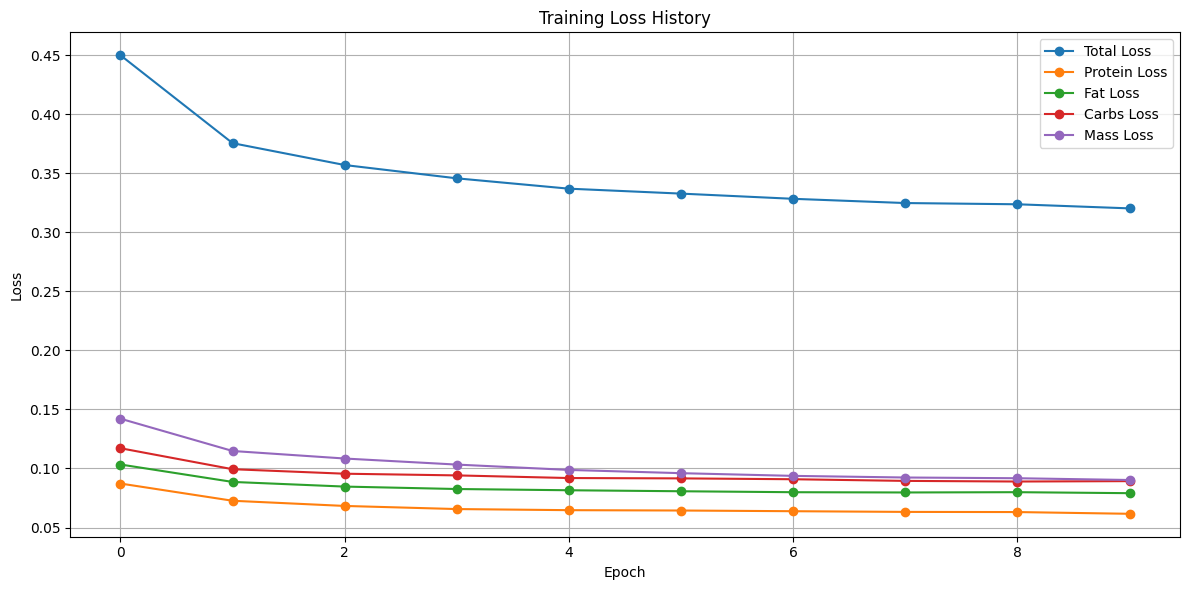

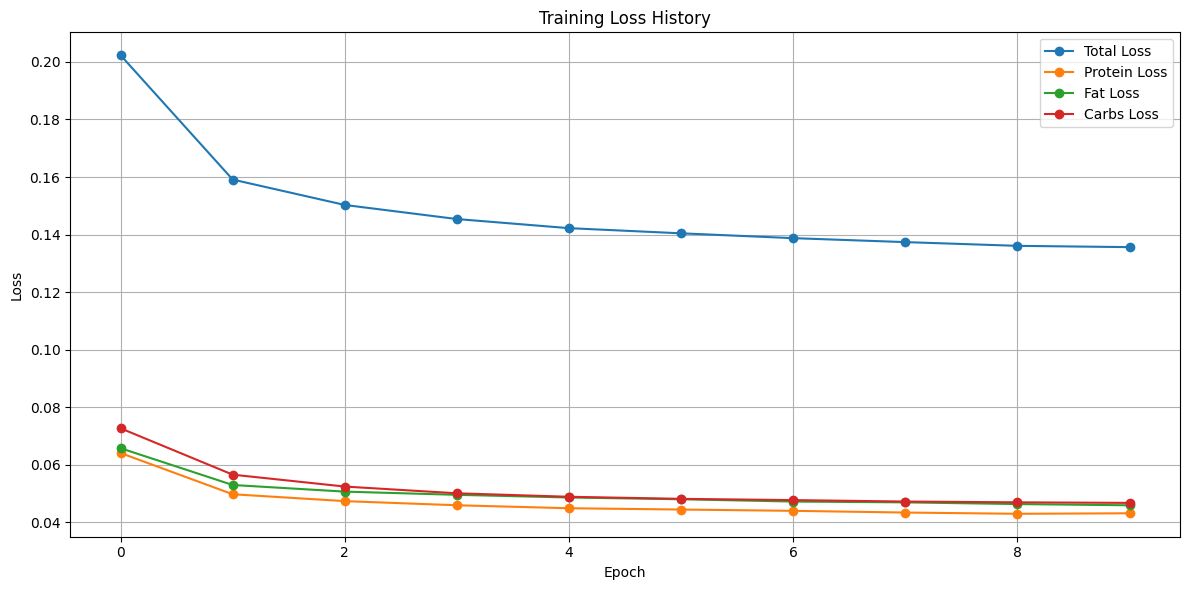

In [38]:
plot_training_history(history_dr, portion_independent=False)
plot_training_history(history_pi, portion_independent=True)

In [34]:
!mkdir "/content/drive/MyDrive/Colab Notebooks/nutrition5k-main/nutrition_model/checkpoints/"

In [35]:
# Save models and training histories
torch.save(direct_regression.state_dict(), '/content/drive/MyDrive/Colab Notebooks/nutrition5k-main/nutrition_model/checkpoints/direct_regression.pth')
torch.save(portion_independent_model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/nutrition5k-main/nutrition_model/checkpoints/portion_independent.pth')
pd.DataFrame(history_dr).to_json('/content/drive/MyDrive/Colab Notebooks/nutrition5k-main/nutrition_model/checkpoints/direct_regression_history.json')
pd.DataFrame(history_pi).to_json('/content/drive/MyDrive/Colab Notebooks/nutrition5k-main/nutrition_model/checkpoints/portion_independent_history.json')

# 5. Plotting Training Losses

In [36]:
def plot_key(history, key, title):
    plt.title(title)
    plt.plot(history[key], label='Training')
    plt.grid()
    plt.legend()
    plt.show()

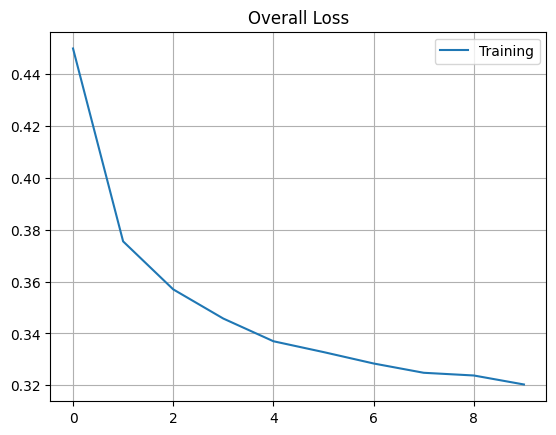

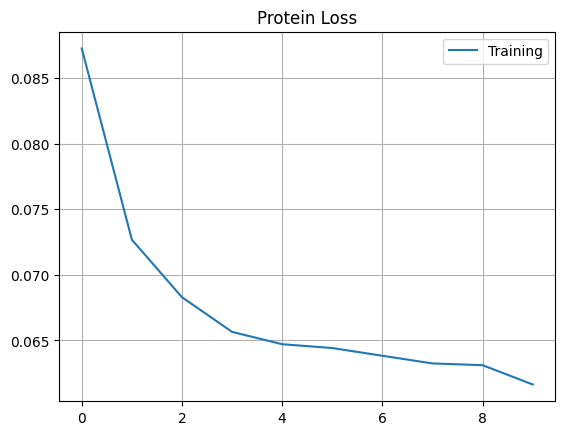

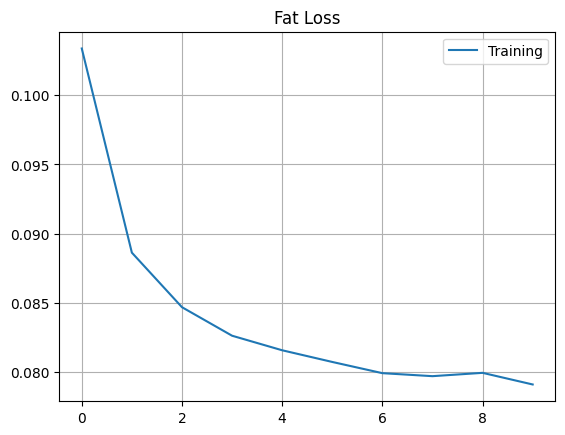

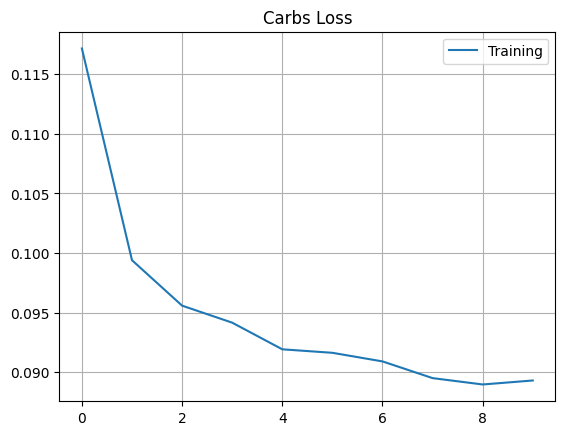

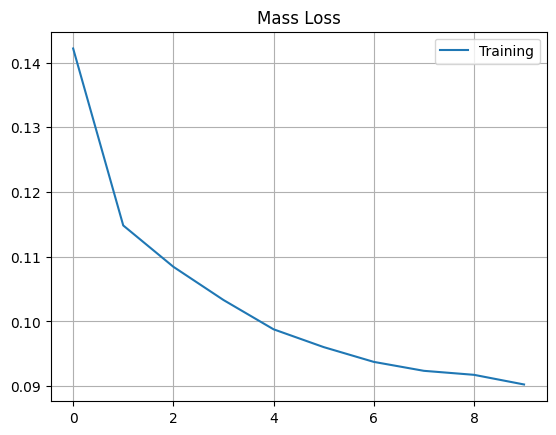

In [37]:
plot_key(history_dr, 'loss', 'Overall Loss')
plot_key(history_dr, 'protein_loss', 'Protein Loss')
plot_key(history_dr, 'fat_loss', 'Fat Loss')
plot_key(history_dr, 'carbs_loss', 'Carbs Loss')
if 'mass_loss' in history_dr:
    plot_key(history_dr, 'mass_loss', 'Mass Loss')

# 6. Prediction and Evaluation

In [39]:
def calories_from_macro(protein, carbs, fat):
    return protein * 4 + carbs * 4 + fat * 9

In [40]:
# For direct regression prediction (with 4 outputs)
def make_direct_prediction(model, img):
    model.eval()
    with torch.no_grad():
        img = img.to(device)
        outputs = model(img)
    # Inverse scale the outputs using the saved scalers (assumes outputs are 1D tensors)
    protein = protein_scaler.inverse_transform(outputs['protein'].cpu().numpy())
    fat = fat_scaler.inverse_transform(outputs['fat'].cpu().numpy())
    carbs = carb_scaler.inverse_transform(outputs['carbs'].cpu().numpy())
    mass = mass_scaler.inverse_transform(outputs['mass'].cpu().numpy())
    protein_val = protein[0][0]
    fat_val = fat[0][0]
    carbs_val = carbs[0][0]
    mass_val = mass[0][0]
    calories = calories_from_macro(protein_val, carbs_val, fat_val)
    return {
        'predictions': {k: v.cpu().numpy() for k, v in outputs.items()},
        'protein': protein_val,
        'fat': fat_val,
        'carbs': carbs_val,
        'calories': calories,
        'mass': mass_val,
    }

In [41]:
# For portion independent prediction (with 3 outputs)
def make_portion_independent_prediction(model, img, total_mass):
    model.eval()
    with torch.no_grad():
        img = img.to(device)
        outputs = model(img)
    protein = outputs['protein'].cpu().numpy()[0][0] * total_mass
    fat = outputs['fat'].cpu().numpy()[0][0] * total_mass
    carbs = outputs['carbs'].cpu().numpy()[0][0] * total_mass
    calories = calories_from_macro(protein, carbs, fat)
    return {
        'predictions': {k: v.cpu().numpy() for k, v in outputs.items()},
        'protein': protein,
        'fat': fat,
        'carbs': carbs,
        'calories': calories,
        'mass': total_mass,
    }

In [42]:
# A helper to randomly select an image from the test set
def random_img(df):
    item = df[df['split'] == 'test'].sample(1)
    img_path = Path(directory) / item['image_link'].values[0]
    image = Image.open(img_path).convert('RGB')
    image = test_transform(image)
    image = image.unsqueeze(0)  # add batch dimension
    return item, image


In [43]:
# Get a random test item and its image tensor
item, img_tensor = random_img(df)

In [44]:
# (Assuming you have a separate classification model for image_model,
#  here we focus on our regression models.)

# Direct regression prediction
direct_output = make_direct_prediction(direct_regression, img_tensor)

In [45]:
# For portion independent prediction, get the total mass from original data.
df_original = pd.read_json('/content/drive/MyDrive/Colab Notebooks/nutrition5k-main/preprocess/filtered_data_cleaned.json', dtype={'total_mass': 'float64'})
original_item = df_original[df_original['id'] == item['id'].values[0]].iloc[0]
portion_independent_output = make_portion_independent_prediction(portion_independent_model, img_tensor, original_item['total_mass'])

In [46]:
def evaluate_item(predicted, actual):
    df_eval = pd.DataFrame([
        [predicted['protein'], actual['total_protein']],
        [predicted['fat'], actual['total_fat']],
        [predicted['carbs'], actual['total_carb']],
        [predicted['calories'], actual['total_calories']],
        [predicted['mass'], actual['total_mass']],
    ], index=['protein', 'fat', 'carbs', 'calories', 'mass'], columns=['predicted', 'actual'])
    return df_eval

In [47]:
eval_direct = evaluate_item(direct_output, original_item)
eval_portion = evaluate_item(portion_independent_output, original_item)
print("Direct Regression Evaluation:")
print(eval_direct)
print("\nPortion Independent Evaluation:")
print(eval_portion)

Direct Regression Evaluation:
           predicted      actual
protein     7.545512   26.656000
fat         8.353929   58.904999
carbs      15.774654   27.013000
calories  168.466019  687.939026
mass       88.652077  119.000000

Portion Independent Evaluation:
           predicted      actual
protein     8.192226   26.656000
fat         7.946879   58.904999
carbs      14.871579   27.013000
calories  163.777124  687.939026
mass      119.000000  119.000000
